# Visualization and Interpretation

The aim of this notebook is to visualize and interpret which features are most crucial in classifying audio recording environments. To explain the degree to which a particular feature influences the classification outcome, `SHAP` will be utilized.

In [1]:
import shap
import numpy as np
import pandas as pd
import keras
import pickle
from keras.models import load_model
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

# Load the Keras model
model = load_model('../model_final/')

/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-19 00:46:53.664606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 00:46:56.534474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Tenso

In [2]:
aggregated_data = pickle.load( open( '../data/processed/20230304/aggregated_data', 'rb' ) )

[train_mps_raw_pca, valid_mps_raw_pca, test_mps_raw_pca,
    train_mps_bg_pca, valid_mps_bg_pca, test_mps_bg_pca,
    train_mps_fg_pca, valid_mps_fg_pca, test_mps_fg_pca,
    train_indices_raw_pca, valid_indices_raw_pca, test_indices_raw_pca,
    train_indices_bg_pca, valid_indices_bg_pca, test_indices_bg_pca,
    train_indices_fg_pca, valid_indices_fg_pca, test_indices_fg_pca,
    train_embedding_raw_pca, valid_embedding_raw_pca, test_embedding_raw_pca,
    train_embedding_bg_pca, valid_embedding_bg_pca, test_embedding_bg_pca,
    train_embedding_fg_pca, valid_embedding_fg_pca, test_embedding_fg_pca,
    train_vgg_raw_pca, valid_vgg_raw_pca, test_vgg_raw_pca,
    train_vgg_bg_pca, valid_vgg_bg_pca, test_vgg_bg_pca,
    train_vgg_fg_pca, valid_vgg_fg_pca, test_vgg_fg_pca,
    train_panns_clip_raw_pca, valid_panns_clip_raw_pca, test_panns_clip_raw_pca,
    train_panns_clip_bg_pca, valid_panns_clip_bg_pca, test_panns_clip_bg_pca,
    train_panns_clip_fg_pca, valid_panns_clip_fg_pca, test_panns_clip_fg_pca,
    train_panns_embedding_raw_pca, valid_panns_embedding_raw_pca, test_panns_embedding_raw_pca,
    train_panns_embedding_bg_pca, valid_panns_embedding_bg_pca, test_panns_embedding_bg_pca,
    train_panns_embedding_fg_pca, valid_panns_embedding_fg_pca, test_panns_embedding_fg_pca,
    y_train, y_valid, y_test] = aggregated_data

train_data_raw = np.concatenate((train_mps_raw_pca, train_indices_raw_pca, train_panns_embedding_raw_pca), axis = 1)
valid_data_raw = np.concatenate((valid_mps_raw_pca, valid_indices_raw_pca, valid_panns_embedding_raw_pca), axis = 1)
test_data_raw = np.concatenate((test_mps_raw_pca, test_indices_raw_pca, test_panns_embedding_raw_pca), axis = 1)


In [3]:
# make feature names

feature_names = []
for n in range(10):
    feature_names.append('mps_'+str(n).zfill(3))
    
for n in range(20):
    feature_names.append('indices_'+str(n).zfill(3))
    
for n in range(400):
    feature_names.append('panns_'+str(n).zfill(3))

In [4]:
# Create a function that takes the input data and returns the output of the Keras model. 
# This is necessary because SHAP needs a function that takes a single input and returns a single output.

def predict_fn(x):
    return model.predict(x)

np.random.seed(23)
n_samples = 2000 # randomly samples some data to run SHAP, as it would be slow to use all samples
background = train_data_raw[np.random.choice(train_data_raw.shape[0], n_samples, replace=False)]

# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

# compute shap values
shap_values = explainer.shap_values(test_data_raw)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


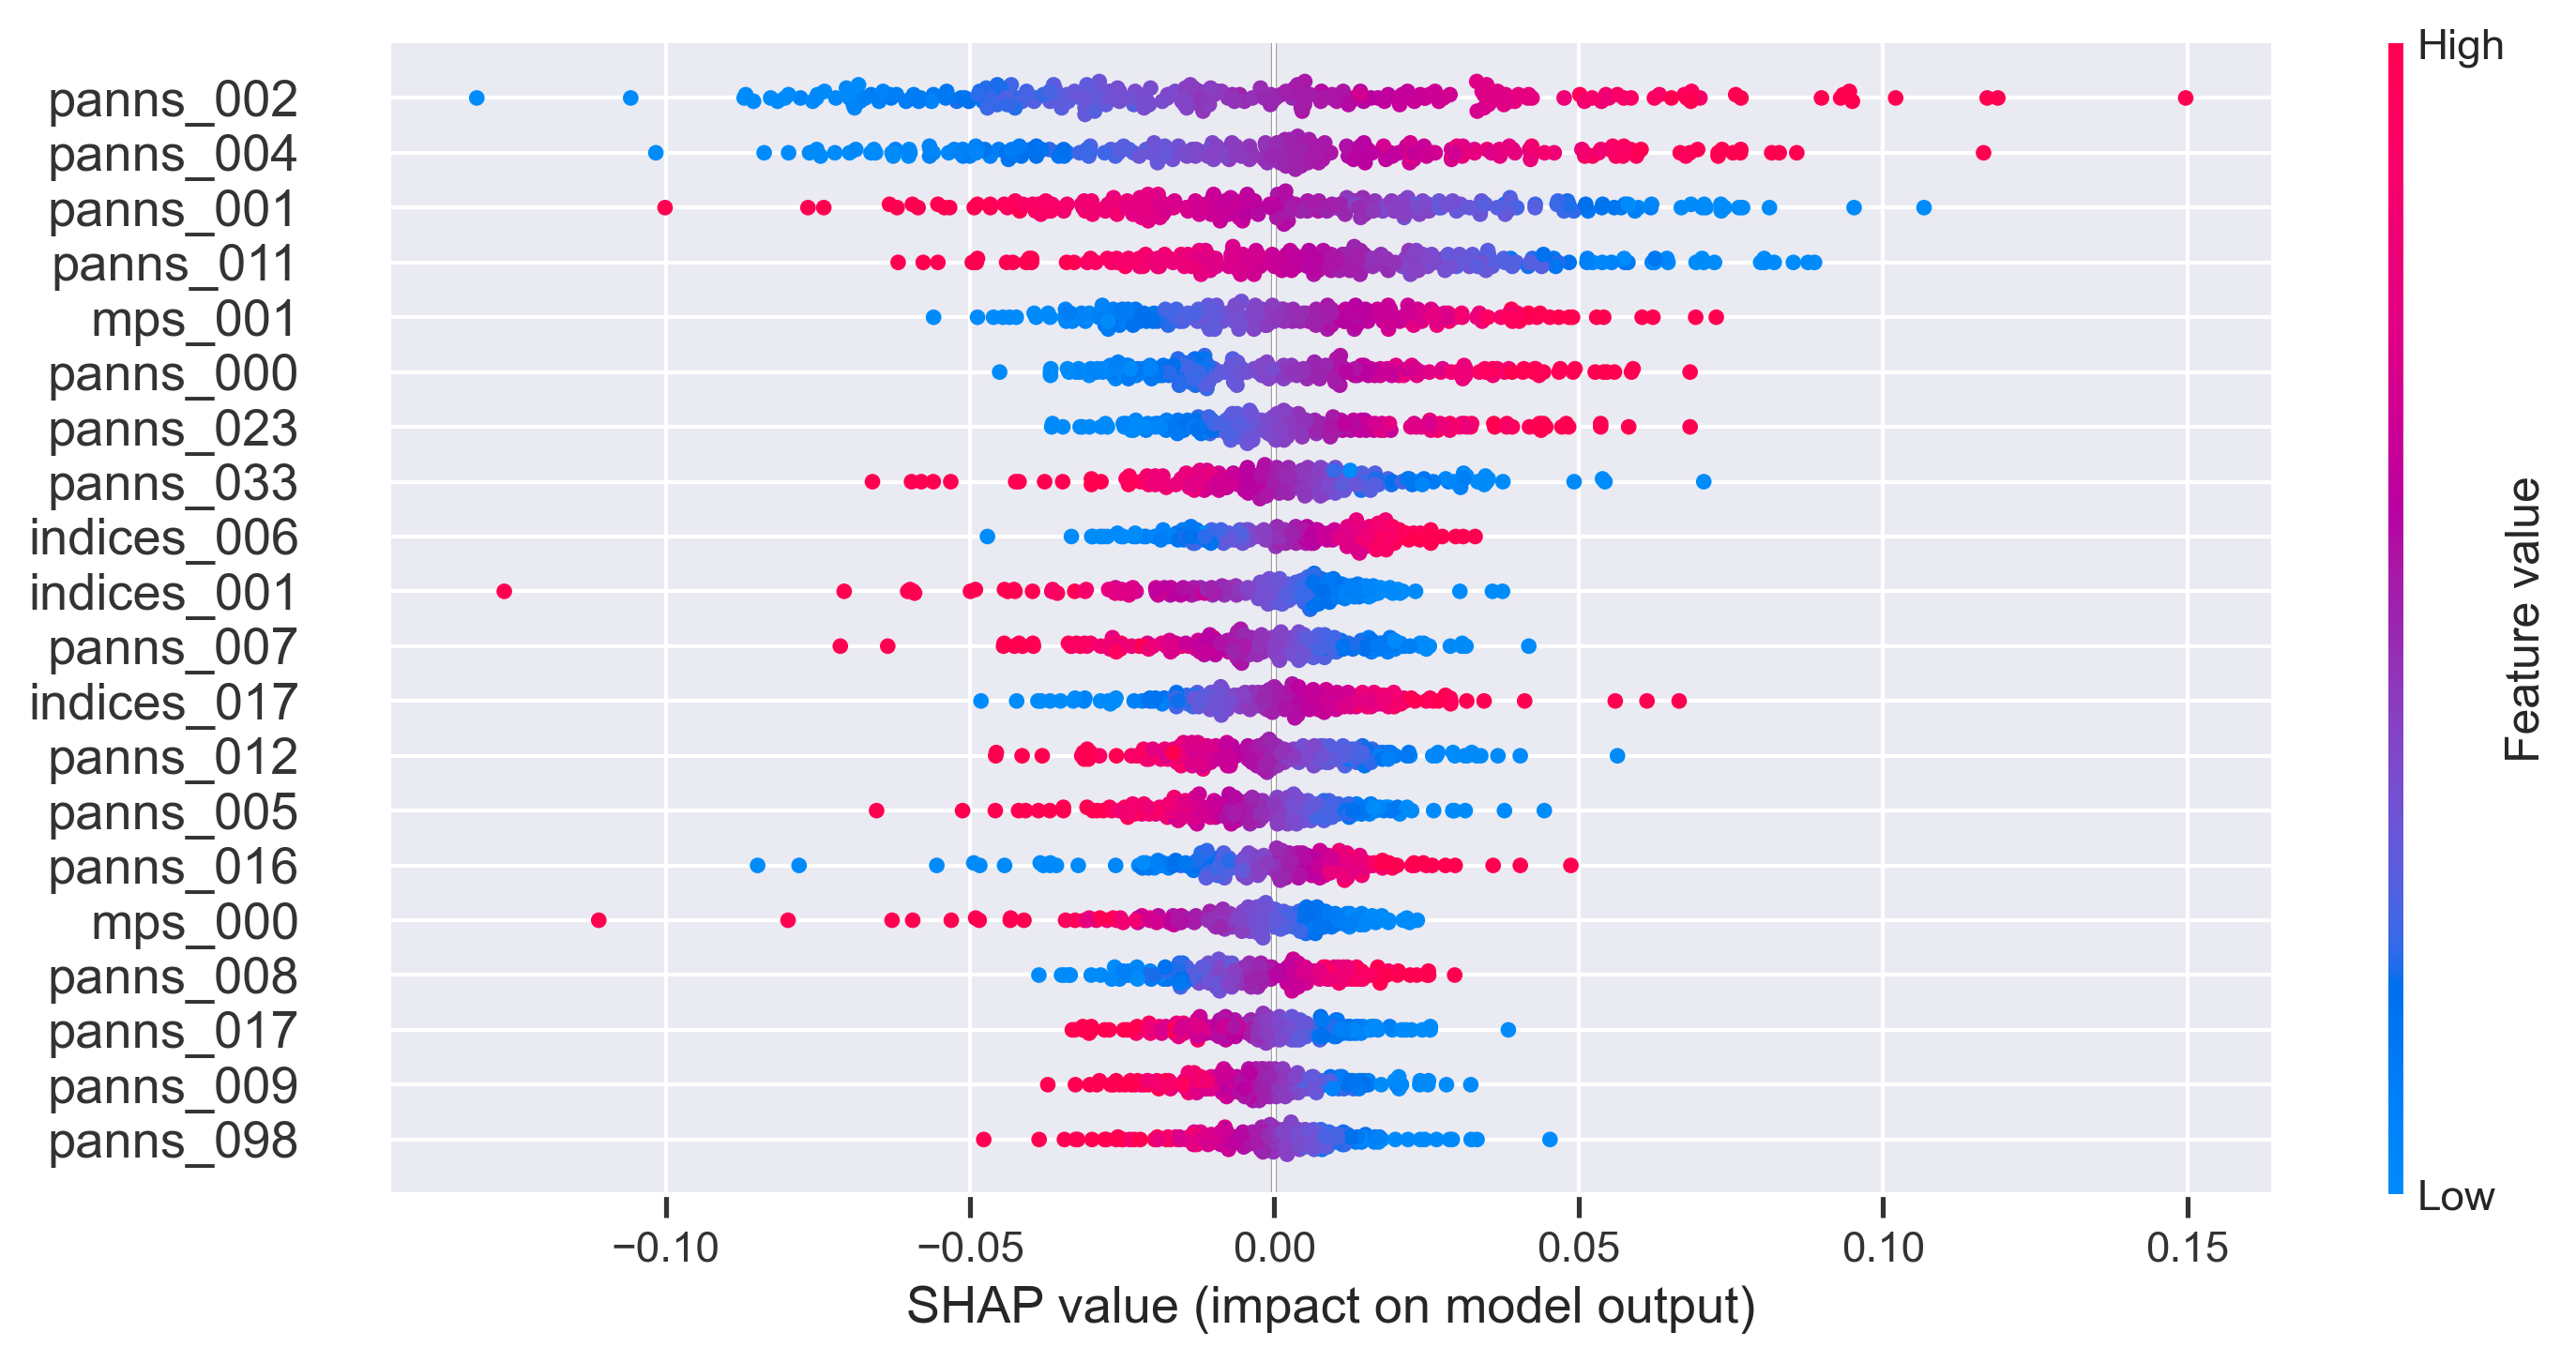

In [5]:
shap.summary_plot(shap_values[0], test_data_raw, feature_names=feature_names, max_display = 20, plot_size = (10,5), show=False)

As all the features have been transformed into PC-space to reduce the number of dimensions before training a deep learning model, the SHAP results consist of PCs of the soundscape indices (`indices_XXX`), spectrotemporal modulation spectrum (`mps_XXX`), and embeddings of the PANNs model (`panns_XXX`). **Among the top 20 critical features, there are 3 PCs of soundscape indices, 2 PCs of spectrotemporal modulation spectrum, and 15 PCs of PANNs embeddings.** While this finding suggests that the audio CNN model (i.e., PANNs) pre-trained on a large sample is highly effective for transfer learning in classifying audio environments, the features obtained via a hypothesis-driven signal processing approach remain useful.

# Converting PCs back to original features

In this stage, I will map the weights of the critical PCs of the soundscape indices and spectrotemporal modulation spectrum identified by SHAP to the original features. This will allow us to inspect what the critical original features are.

Please note that since the embeddings of the PANNs model are not explainable, we will skip this conversion step for PANNs.

In [6]:
# load data
import pickle
file = open('../data/processed/20230304/PCA_transformer/mps_raw', 'rb')
mps_raw_PCA = pickle.load(file)
file.close()

file = open('../data/processed/20230304/PCA_transformer/indices_raw', 'rb')
indices_raw_PCA = pickle.load(file)
file.close()

In [7]:
# mapping components' weights
indices_pca_weights = indices_raw_PCA.named_steps['PCA'].components_
mps_pca_weights = mps_raw_PCA.named_steps['PCA'].components_

indices_pc6_weights = indices_pca_weights[6,:]
indices_pc1_weights = indices_pca_weights[1,:] * -1 # multiply by -1 as the polarity on the SHAP is reversed
indices_pc17_weights = indices_pca_weights[17,:]

mps_pc1_weights = mps_pca_weights[1,:].reshape(77,101)
mps_pc0_weights = mps_pca_weights[0,:].reshape(77,101) * -1 # multiply by  -1 as the polarity on the SHAP is reversed

## Visualizing the weights of spectrotemporal modulation spectrum

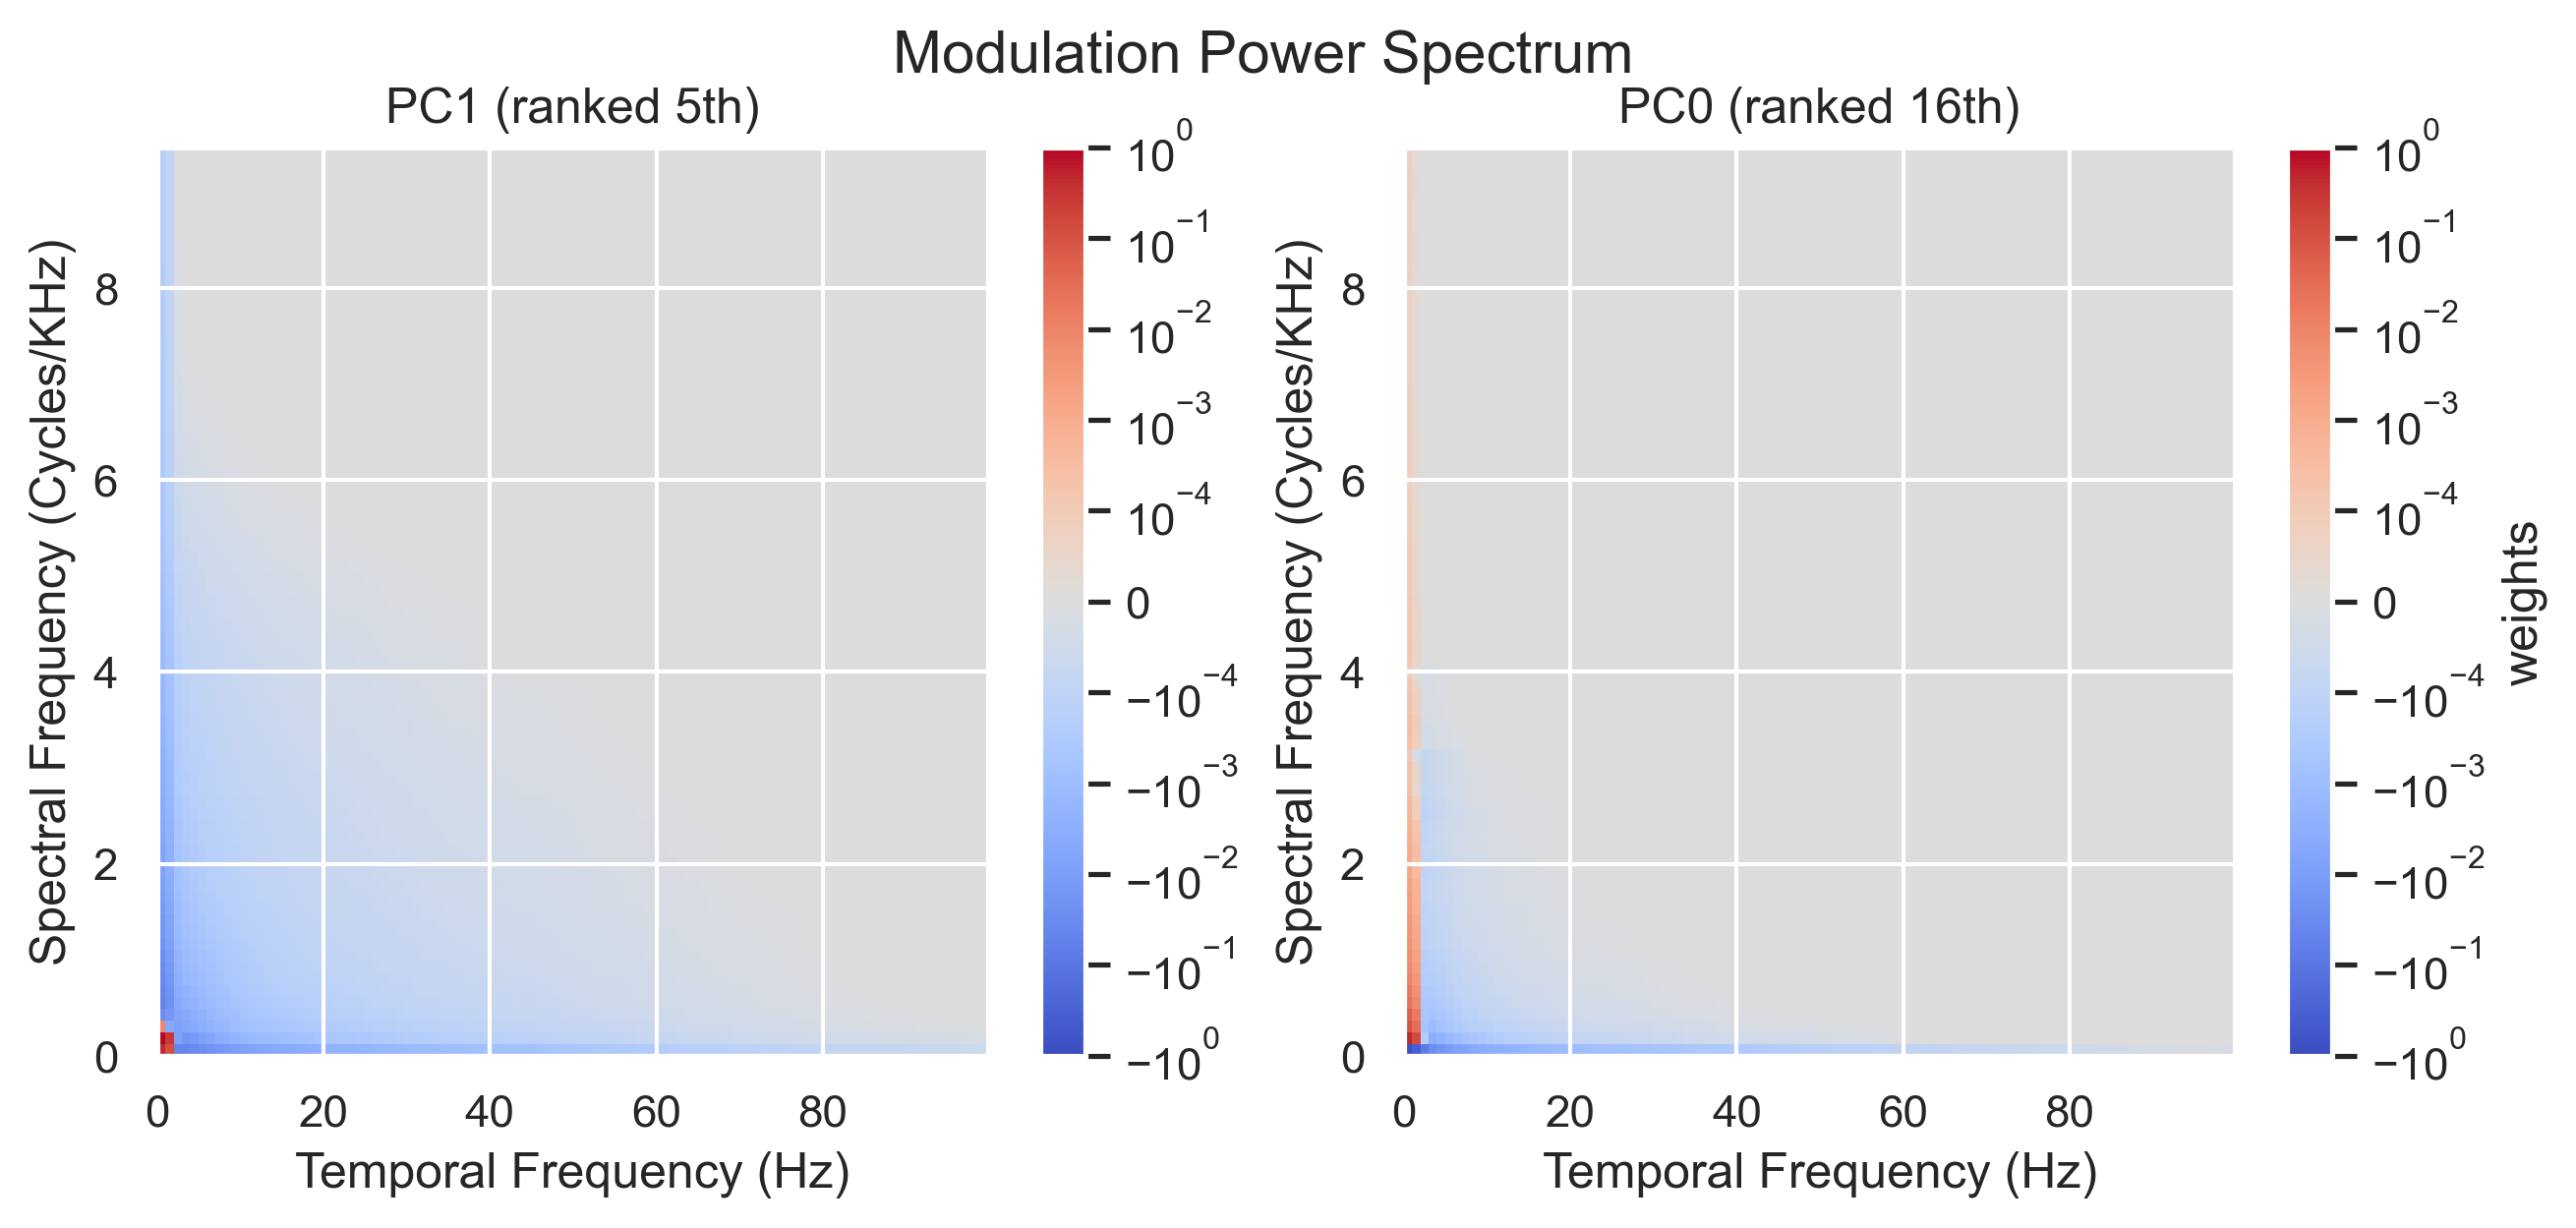

In [16]:
# getting the axis from one file
import pickle
df_all = pd.read_csv('../train_val_test_split/train_val_test_GoogleAudioSet.csv', index_col=0)
file = open(df_all.loc[0,'file'], 'rb')
output = pickle.load(file)
wt_ind = output['wt']<=100
wt = output['wt'][output['wt']<=100]
wf = output['wf']
file.close()

import matplotlib.colors as colors

# plot
fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(10,4)) 
cmap = plt.get_cmap('coolwarm')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
img1 = ax1.imshow(mps_pc1_weights, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, norm=colors.SymLogNorm(linthresh=0.00001, linscale=0.00001,
                                              vmin=-1.0, vmax=1.0, base=10))
ax1.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax1.set_xlabel('Temporal Frequency (Hz)')
img2 = ax2.imshow(mps_pc0_weights, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, norm=colors.SymLogNorm(linthresh=0.00001, linscale=0.00001,
                                              vmin=-1.0, vmax=1.0, base=10))
ax2.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax2.set_xlabel('Temporal Frequency (Hz)')
cbar1 = fig.colorbar(img1, ax=ax1)
cbar1.set_ticks([-1, -0.1, -0.01, -0.001, -0.0001, 0, 0.0001, 0.001, 0.01, 0.1, 1])
cbar2 = fig.colorbar(img2, ax=ax2)
cbar2.set_ticks([-1, -0.1, -0.01, -0.001, -0.0001, 0, 0.0001, 0.001, 0.01, 0.1, 1])
cbar2.ax.set_ylabel('weights')
plt.ylim((0,wf.max()*1e3))
ax1.title.set_text('PC1 (ranked 5th)')
ax2.title.set_text('PC0 (ranked 16th)')
plt.suptitle('Modulation Power Spectrum')
plt.show()

The plots reveal that the low frequency region in both the spectral and temporal modulation domains is critical for accurately classifying audio environments. This finding is also supported by the exploratory data analysis, which revealed that the t-test identified the most significant group difference in the same region. This is not surprising since this frequency range is more prevalent in the acoustic world, such as in speech, music, machine sounds, and animal calls, and therefore, these features are informative for classification purposes.

## Visualizing the weights of top soundscape indices

In [17]:
# load data
df_indices_raw = pd.read_csv('../data/processed/20230304/df_indices_raw.csv', index_col=0)
indices_columns = df_indices_raw.columns
indices_pcWeights = pd.DataFrame(np.stack((indices_pc6_weights,indices_pc1_weights,indices_pc17_weights), axis = 0), columns=indices_columns, index=['PC6 (ranked 9th)','PC1 (ranked 10th)','PC17 (ranked 12th)'])
indices_pcWeights

,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,MED,Ht,...,TFSD,H_Havrda,H_Renyi,H_pairedShannon,H_gamma,H_GiniSimpson,RAOQ,AGI,ROItotal,ROIcover
PC6 (ranked 9th),0.006510,-5.157579e-14,-9.332030e-14,0.000764,0.050250,3.234517e-05,0.041623,-0.045817,0.000771,0.000971,...,-0.000437,-1.068438e-05,-0.001849,-0.001431,-0.000617,-0.000115,-0.000099,-0.056141,0.032028,0.004181
PC1 (ranked 10th),-0.997067,-4.457938e-15,-2.118069e-14,0.000001,0.005107,4.818177e-07,0.000388,-0.000428,0.000010,0.000014,...,-0.000069,-2.624516e-07,-0.000055,-0.000062,0.069046,-0.000003,-0.000035,0.001601,-0.002907,-0.000737
PC17 (ranked 12th),0.000002,-5.349484e-13,2.825847e-11,0.062716,0.002245,-2.541059e-03,-0.645544,0.105629,-0.000105,0.027719,...,-0.002310,-5.850944e-05,0.001789,-0.010861,0.000036,-0.000616,-0.003457,-0.001189,0.007283,0.018637


In [18]:
# pick the top 15 features
top_features = list(indices_pcWeights.abs().max().sort_values(ascending=False).index[:15])
top_features

['ZCR',
 'ACI',
 'ACTtMean',
 'BGNt',
 'ACTtCount',
 'ROU',
 'ACTspCount',
 'EPS_KURT',
 'EVNtCount',
 'SNRt',
 'ACTspMean',
 'KURTf',
 'H_gamma',
 'SKEWt',
 'AGI']

In [19]:
indices_pcWeights_top = indices_pcWeights[top_features]
indices_pcWeights_top.reset_index(inplace=True)
indices_pcWeights_top_melted = pd.melt(indices_pcWeights_top, value_vars=top_features, id_vars=['index'], var_name='feature', value_name='weight')
indices_pcWeights_top_melted.head()

,index,feature,weight
0,PC6 (ranked 9th),ZCR,0.006510
1,PC1 (ranked 10th),ZCR,-0.997067
2,PC17 (ranked 12th),ZCR,0.000002
3,PC6 (ranked 9th),ACI,-0.792501
4,PC1 (ranked 10th),ACI,-0.001942


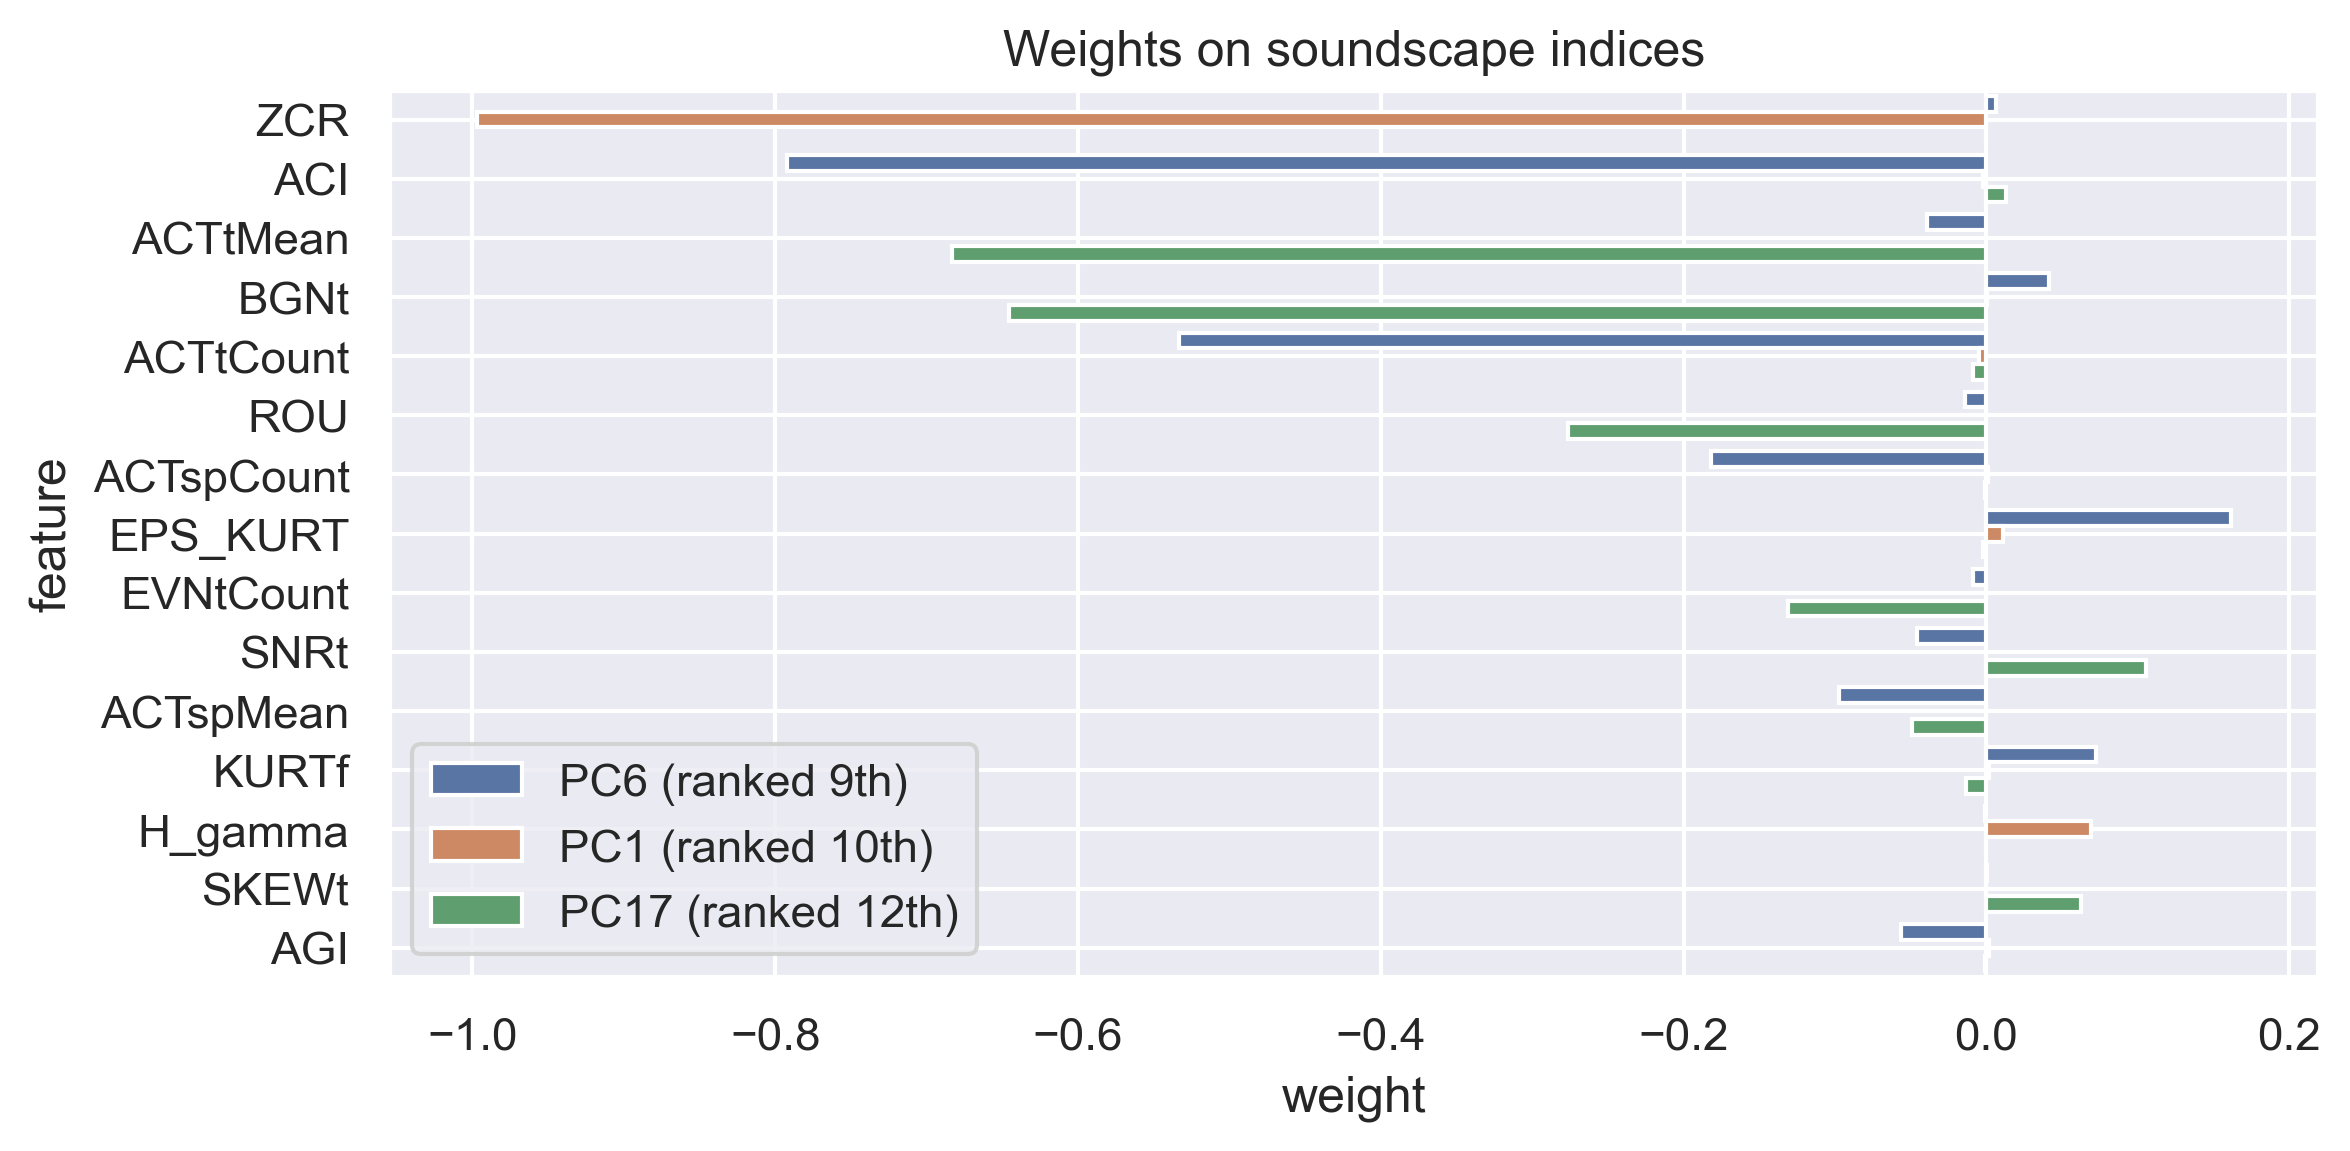

In [20]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8,4))

sns.barplot(data=indices_pcWeights_top_melted , y='feature', x='weight', hue='index', ax=ax)
plt.title('Weights on soundscape indices')
plt.tight_layout()
plt.grid(axis='y')
legend = ax.legend()
# legend.title()
plt.show()

This finding is consistent with numerous previous studies. For example, the zero-crossing rate (`ZCR`) has been an essential feature in machine listening, including speech recognition and music information retrieval. The acoustic complexity index (`ACI`) is useful for quantifying environmental noise levels. Additionally, acoustic activity indices, in both temporal (`ACTtMean`, `ACTtCount`) and spectral (`ACTspCount`, `ACTspMean`) domains, are popular for quantifying the audio signal that reaches a certain threshold.

Interestingly, the deep learning model's top features do not completely overlap with the most significant features identified by t-tests during exploratory data analysis. For example, the SHAP ranked `ZCR` and `ACI` as the most important feature for the current deep learning model, while t-tests did not rank them in the top 20 features. This suggests that the top features may be contributing to classification in a nonlinear manner.

For more in-depth explanations and references, please visit `scikit-maad` at https://scikit-maad.github.io/features.html.